In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
# Set up paths and load data
path = '/home/paperspace/fastai/nba_court_vision'
model=resnet34
sz = 450

label_csv = f'{path}/data/nba_team_label_v7'
label_df = pd.read_csv(label_csv)

In [3]:
from collections import defaultdict
home_team_inds = defaultdict(list)

In [4]:
# Compute validation indices to make sure each game only in one set
# Generate dictionary {team:[home game indices for first picture in set]}
lab_df_short = label_df[label_df.index % 10 == 0].copy()
for start_index, team in zip(lab_df_short.index, lab_df_short['home_team']):
    home_team_inds[team].append(start_index)

# Sample 20% of indices for each team in the dictionary
# to create new list of all validation indices
val_idxs = []
s = 0
for team in home_team_inds.keys():
    n_val_inds = max(math.ceil(len(home_team_inds[team])*.2), 2) # max(20% of inds, 2)
    val_inds_sample = [list(range(ind, ind+10)) for ind \
                       in np.random.choice(home_team_inds[team], n_val_inds, replace=False)]
    [val_idxs.extend(vis for vis in val_inds_sample)]

# Flatten the list using itertools, now have list of validatino indices
import itertools
val_idxs = list(itertools.chain.from_iterable(val_idxs))

In [44]:
def get_data(sz):
    tfms = tfms_from_model(model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(path, 'data', label_csv, tfms=tfms,
                                       val_idxs=val_idxs, bs=16)

In [45]:
data = get_data(450)
learn = ConvLearner.pretrained(model, data, metrics=[accuracy])

In [ ]:
# Use LR finder to select the best learning rate for the problem
lrf = learn.lr_find()
learn.sched.plot()

In [ ]:
# Find learning rate from plot above, finetune final layers of model
lr = .01
learn.fit(lr, 3, cycle_len=1, cycle_mult=1)

In [74]:
# Set up differential learning rates, train on all layers
lrs = [lr/9, lr/3, lr]
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.59551  0.27802  0.92585]                        
[ 1.       0.36674  0.24317  0.94068]                        
[ 2.       0.20613  0.1898   0.95233]                        
[ 3.       0.30344  0.21011  0.94703]                        
[ 4.       0.26137  0.19932  0.94809]                        
[ 5.       0.15998  0.17272  0.95551]                        
[ 6.       0.09391  0.16765  0.96186]                         



In [75]:
# Get predictions and TTA preds
# TTA = Test Time Augmentation = 4 different parts of each photo
preds = learn.predict()
preds_tta = learn.TTA()

In [76]:
team_dict = {i:team for i,team in enumerate(data.classes)}

res_df = pd.DataFrame()
res_df['class_pred'] = np.argmax(preds, axis=1)
res_df['class_pred'] = res_df['class_pred'].map(team_dict)
res_df['class_prob'] = np.exp(np.max(preds, axis=1))

res_df['class_act'] = data.val_y
res_df['class_act'] = res_df['class_act'].map(team_dict)

res_df['class_tta'] = np.argmax(preds_tta[0], axis=1 )
res_df['class_tta'] = res_df['class_tta'].map(team_dict)

res_df['correct'] = (res_df['class_pred'] == res_df['class_act']).astype(int)

res_df['correct_tta'] = (res_df['class_tta'] == res_df['class_act']).astype(int)
res_df['file'] = data.val_ds.fnames

In [77]:
res_df['correct'].mean(), res_df['correct_tta'].mean()

(0.96129032258064517, 0.967741935483871)

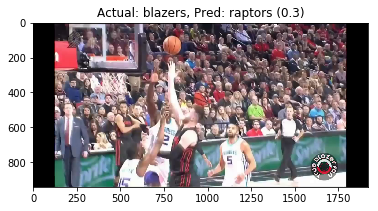

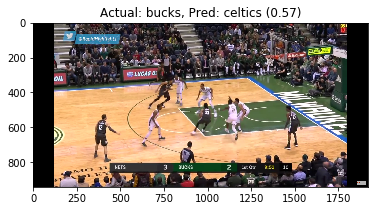

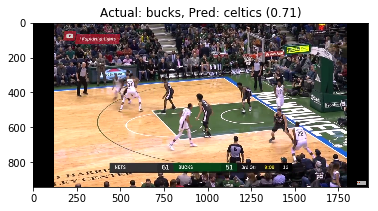

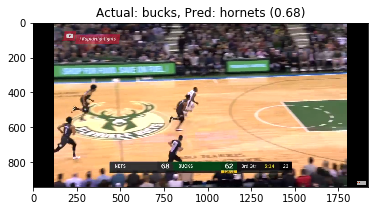

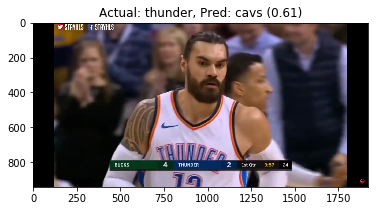

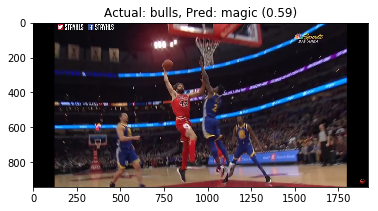

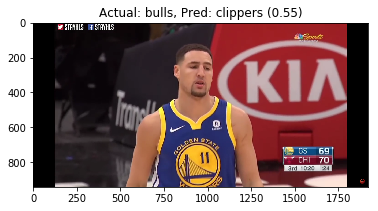

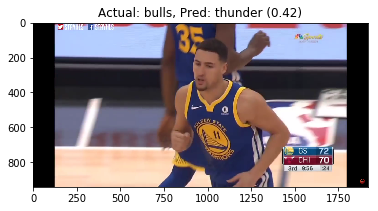

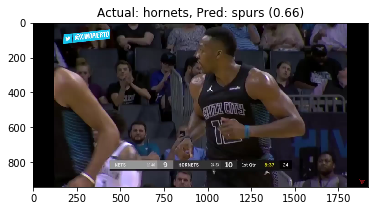

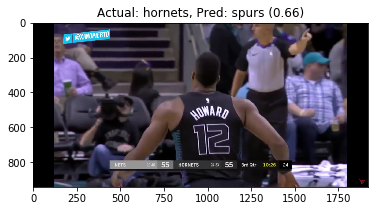

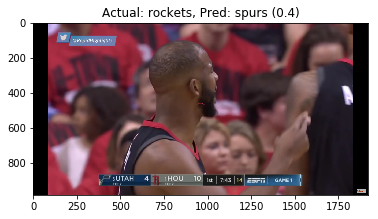

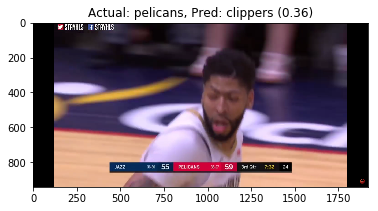

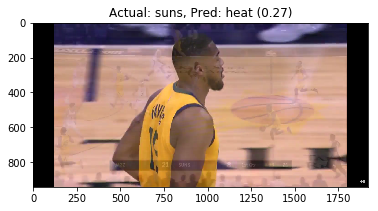

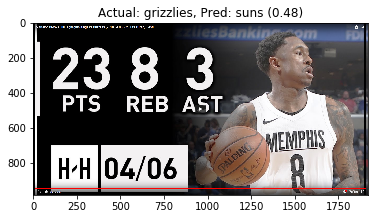

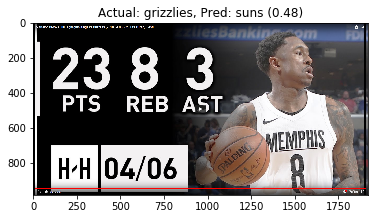

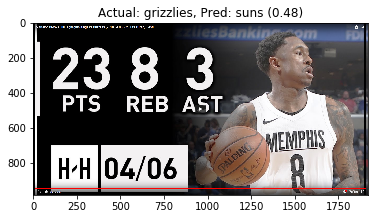

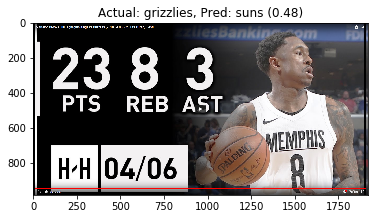

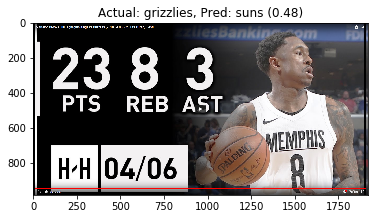

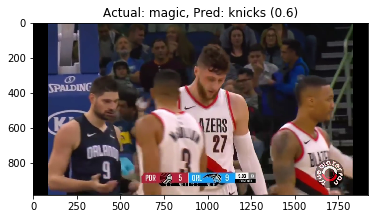

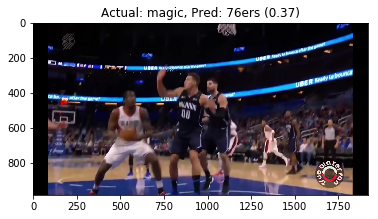

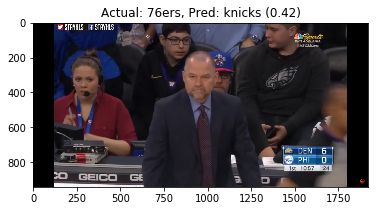

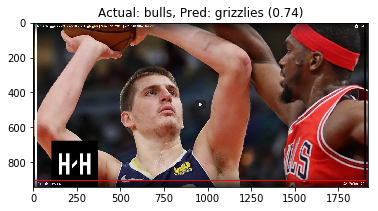

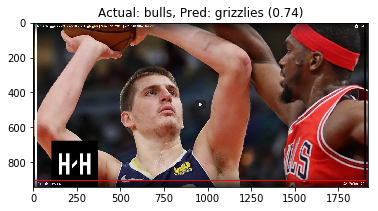

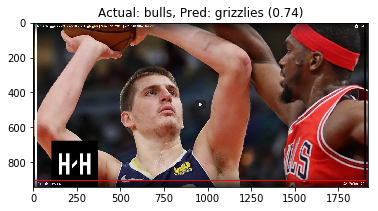

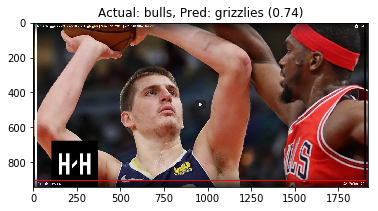

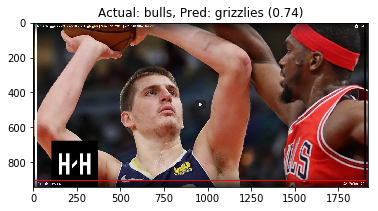

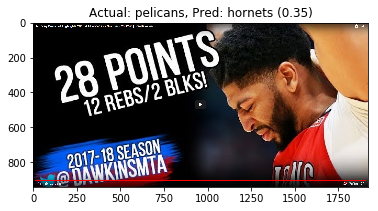

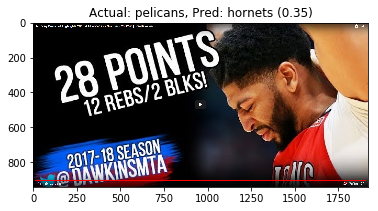

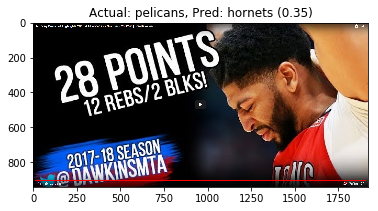

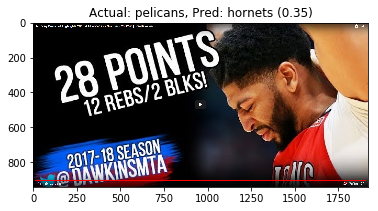

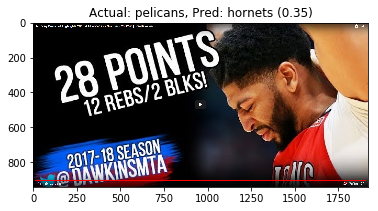

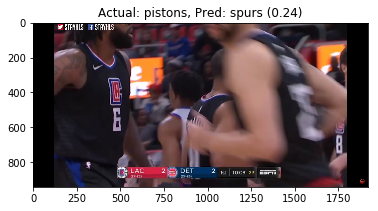

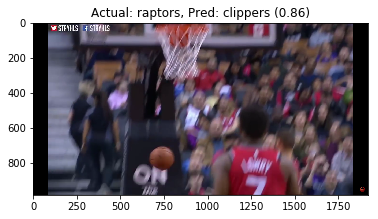

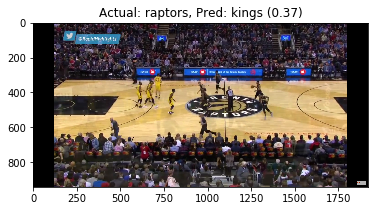

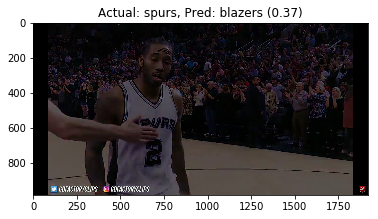

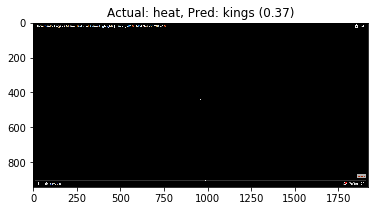

In [79]:
# look at wrong images
wrong = res_df[res_df['correct'] == 0].copy()

for i in wrong.index:
    r = wrong[wrong.index == i].copy().to_dict()
    plt.imshow(plt.imread(r['file'][i]))
    plt.title(f"Actual: {r['class_act'][i]}, Pred: {r['class_pred'][i]} ({round(r['class_prob'][i], 2)})")
    plt.show()

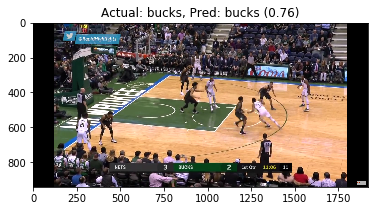

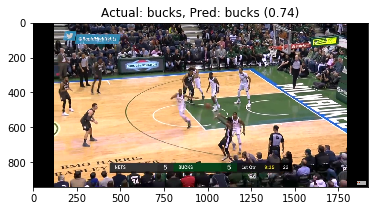

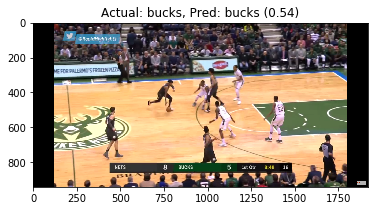

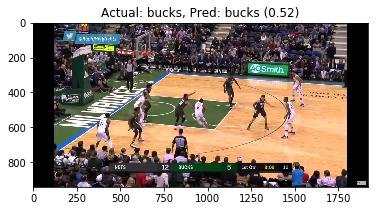

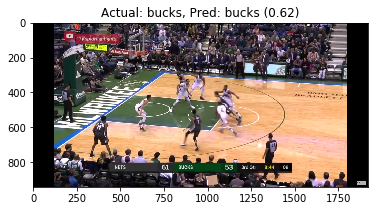

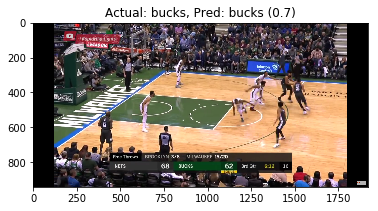

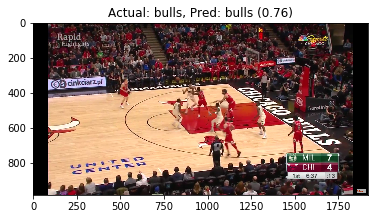

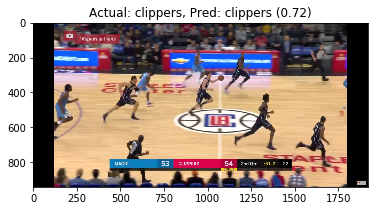

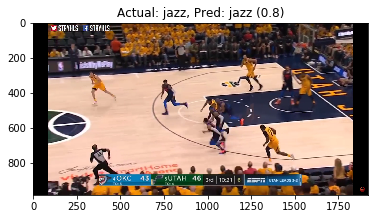

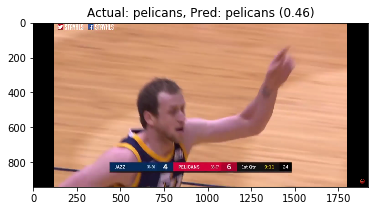

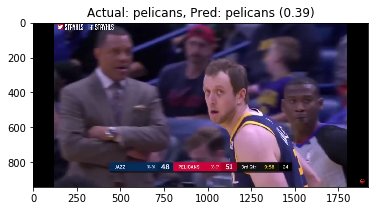

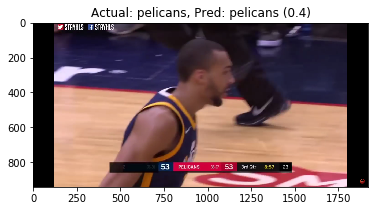

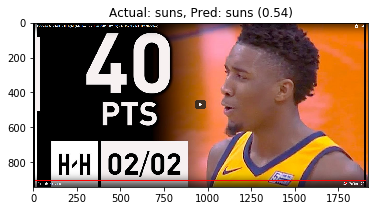

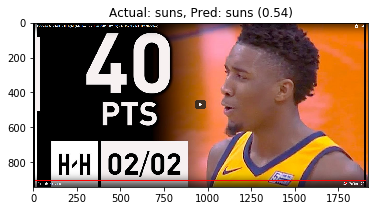

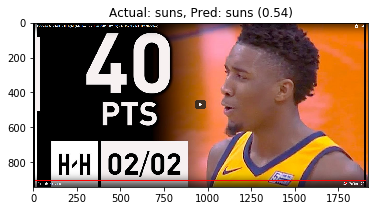

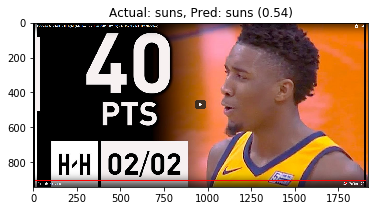

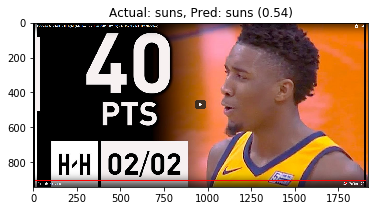

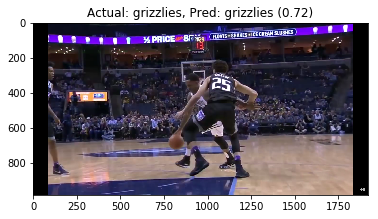

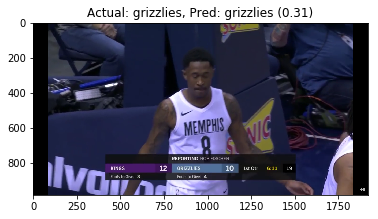

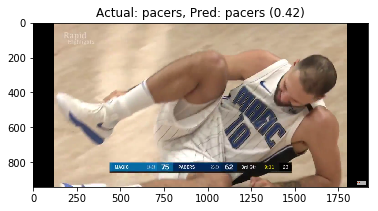

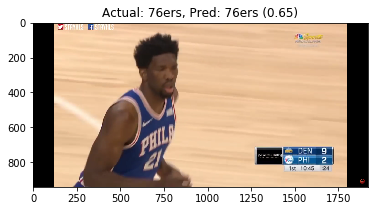

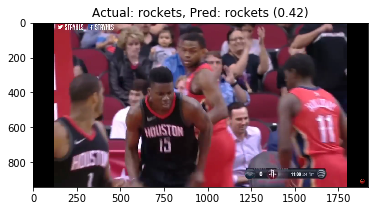

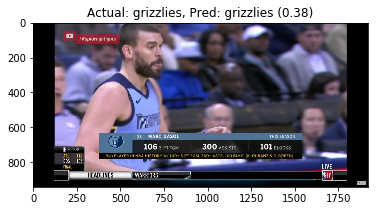

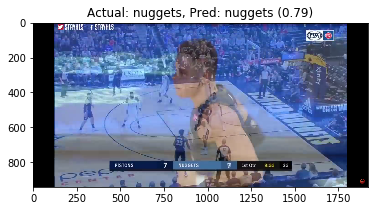

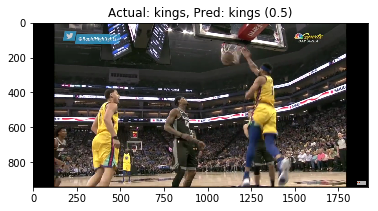

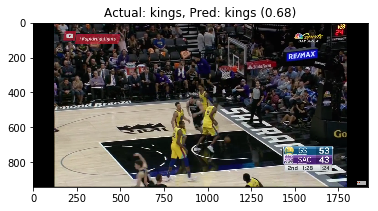

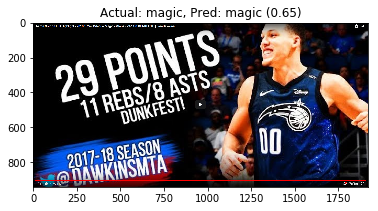

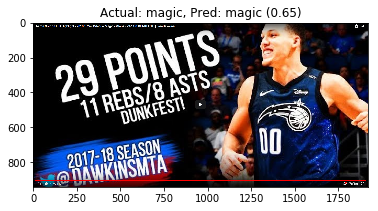

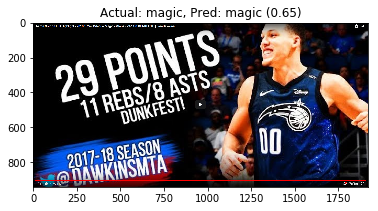

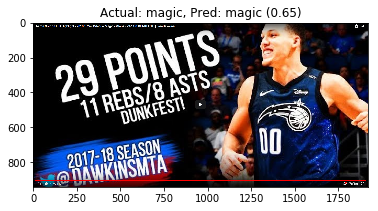

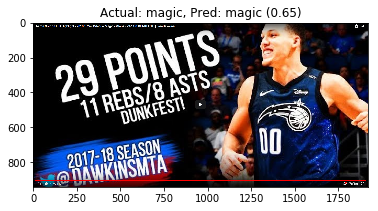

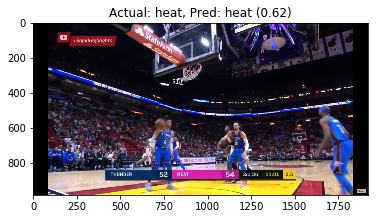

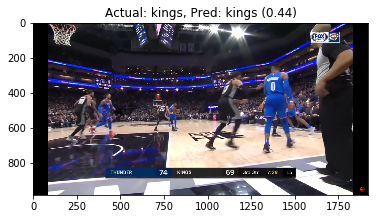

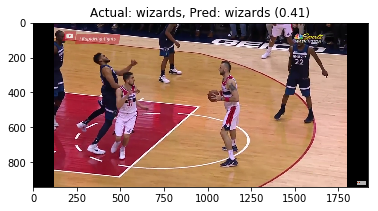

In [85]:
# Look at right photos w/ preds
right = res_df[res_df['correct'] == 1].copy()

for i in right.index:
    r = right[right.index == i].copy().to_dict()
    if round(r['class_prob'][i], 2) > .8: continue
    plt.imshow(plt.imread(r['file'][i]))
    plt.title(f"Actual: {r['class_act'][i]}, Pred: {r['class_pred'][i]} ({round(r['class_prob'][i], 2)})")
    plt.show()

In [ ]:
learn.load('old_models/home_court_model_v1_5.30.18')

In [ ]:
preds = learn.predict()
preds_tta = learn.TTA()

In [ ]:
res_df['correct'].mean(), res_df['correct_tta'].mean()

In [ ]:
wrong = res_df[res_df['correct'] == 1].copy()

In [ ]:
wrong.shape[0]

In [ ]:
wrong

In [ ]:
wrong.index

In [ ]:
r['file']

In [ ]:
wrong[wrong.index == 102].copy().to_dict()

In [ ]:
wrong[wrong['class_prob'] == wrong['class_prob'].min()]

In [ ]:
i = 643

In [ ]:
r = wrong[wrong.index == 643].copy().to_dict()
plt.imshow(plt.imread(r['file'][i]))
plt.title(f"Actual: {r['class_act'][i]}, Pred: {r['class_pred'][i]} ({round(r['class_prob'][i], 2)})")
plt.show()

In [ ]:
for i in wrong.index:
    r = wrong[wrong.index == i].copy().to_dict()
    plt.imshow(plt.imread(r['file'][i]))
    plt.title(f"Actual: {r['class_act'][i]}, Pred: {r['class_pred'][i]} ({round(r['class_prob'][i], 2)})")
    plt.show()

In [ ]:
res_df['class_act'].head()

In [ ]:
len(data.val_y)

In [ ]:
916/930

In [ ]:
927/930